In [3]:
%load_ext autoreload
%autoreload 2


In [4]:
import csv
import pandas as pd
import numpy as np
from packer import Packer
import matplotlib.pyplot as plt
from tqdm import tqdm


In [11]:
df = pd.read_csv('dataset.csv', sep=',')
print(df.head(22))

    Order_ID  Product_ID  Quantity   L   W
0          1           0         5  29  19
1          1           1         5  29  19
2          1           2        10  29  19
3          1           3         4  29  19
4          1           4         6  29  19
5          1           5        10  29  19
6          1           6         2  39  26
7          1           7         2  39  26
8          1           8         2  46  15
9          1           9         2  46  15
10         1          10         1  40  26
11         1          11         1  40  26
12         1          12         2  40  26
13         1          13         2  40  26
14         1          14         1  40  26
15         1          15         1  40  26
16         1          16         1  32  21
17         1          17         1  32  21
18         1          18         1  32  21
19         1          19         1  32  21
20         2           0         4  39  26
21         2           1         2  39  26


In [161]:
results = []
for order_id, order in tqdm(df.groupby("Order_ID")):
    packer = Packer(order)

    packer.pack()

    liquid_filling = (order["Quantity"] * order["L"] * order["W"]).sum() / (100*120)
    amount_of_layers = len(packer.packed_items.layers)
    results.append([order_id, liquid_filling, amount_of_layers])

results_df = pd.DataFrame(results, columns=["Order_ID", "Liquid_Filling", "Amount_of_Layers"])
print(results_df["Amount_of_Layers"].sum())

100%|██████████| 2361/2361 [00:48<00:00, 48.34it/s]

10677


      Order_ID  Liquid_Filling  Amount_of_Layers     Error
1127      1188        6.303917                 9  2.696083
1806      1912        6.777500                 9  2.222500
717        752        6.866083                 9  2.133917
1233      1301        6.926333                 9  2.073667
495        516        5.946500                 8  2.053500
574        599        6.001167                 8  1.998833
1969      2080        5.083167                 7  1.916833
1333      1410        6.084000                 8  1.916000
2172      2296        6.095167                 8  1.904833
1361      1438        4.099417                 6  1.900583
10677


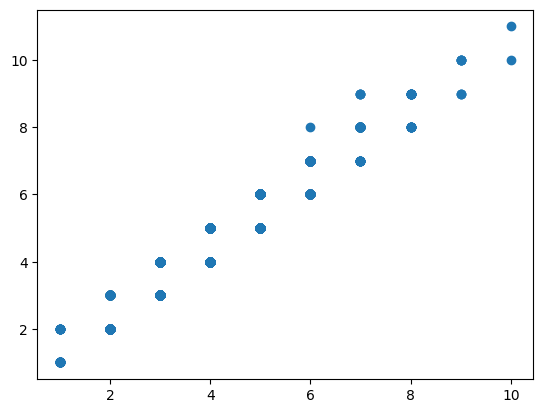

In [162]:
results_df["Error"] = results_df["Amount_of_Layers"] - results_df["Liquid_Filling"]
results_df.sort_values(by=["Error"], ascending=False, inplace=True)
print(results_df.head(10))
print(results_df["Amount_of_Layers"].sum())
plt.scatter(np.ceil(results_df["Liquid_Filling"]), results_df["Amount_of_Layers"])
plt.show()

In [139]:
# interesting_orders = [1,2151,2421,306]
interesting_orders = [1]

Order ID:  1


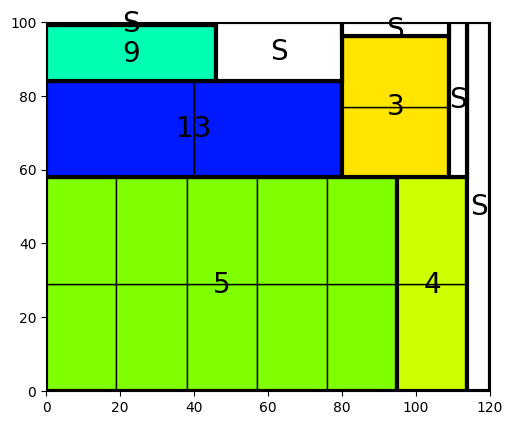

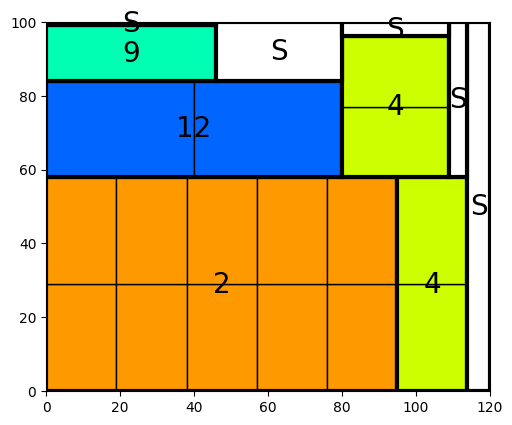

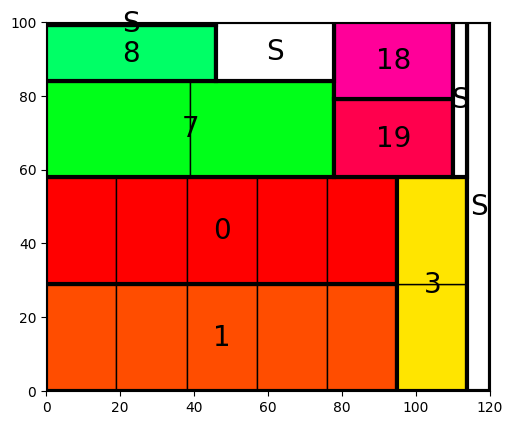

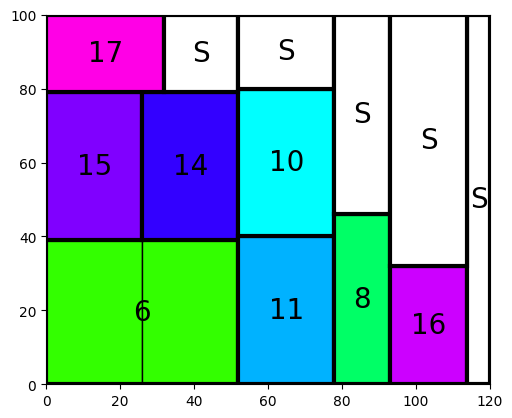

[(29, 19, 1, 0), (19, 29, 1, 0), (29, 38, 2, 0), (19, 58, 2, 0), (58, 19, 2, 0), (38, 29, 2, 0), (29, 57, 3, 0), (19, 87, 3, 0), (87, 19, 3, 0), (57, 29, 3, 0), (29, 76, 4, 0), (58, 38, 4, 0), (38, 58, 4, 0), (116, 19, 4, 0), (76, 29, 4, 0), (29, 95, 5, 0), (95, 29, 5, 0), (29, 19, 1, 1), (19, 29, 1, 1), (29, 38, 2, 1), (19, 58, 2, 1), (58, 19, 2, 1), (38, 29, 2, 1), (29, 57, 3, 1), (19, 87, 3, 1), (87, 19, 3, 1), (57, 29, 3, 1), (29, 76, 4, 1), (58, 38, 4, 1), (38, 58, 4, 1), (116, 19, 4, 1), (76, 29, 4, 1), (29, 95, 5, 1), (95, 29, 5, 1), (29, 19, 1, 2), (19, 29, 1, 2), (29, 38, 2, 2), (19, 58, 2, 2), (58, 19, 2, 2), (38, 29, 2, 2), (29, 57, 3, 2), (19, 87, 3, 2), (87, 19, 3, 2), (57, 29, 3, 2), (29, 76, 4, 2), (58, 38, 4, 2), (38, 58, 4, 2), (116, 19, 4, 2), (76, 29, 4, 2), (29, 95, 5, 2), (95, 29, 5, 2), (58, 57, 6, 2), (38, 87, 6, 2), (87, 38, 6, 2), (57, 58, 6, 2), (114, 29, 6, 2), (58, 76, 8, 2), (116, 38, 8, 2), (76, 58, 8, 2), (87, 57, 9, 2), (57, 87, 9, 2), (58, 95, 10, 2), (

In [164]:
order_ids = interesting_orders

for order_id in order_ids:
    print("Order ID: ", order_id)
    order = df[df["Order_ID"] == order_id]
    packer = Packer(order)
    packer.pack()
    packer.visualise()

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.33333333e-05 1.66666667e-04 ... 7.77777778e-03
  8.05555556e-03 8.33333333e-03]
 [0.00000000e+00 1.66666667e-04 3.33333333e-04 ... 1.55555556e-02
  1.61111111e-02 1.66666667e-02]
 ...
 [0.00000000e+00 9.33333333e-03 1.86666667e-02 ... 8.71111111e-01
  9.02222222e-01 9.33333333e-01]
 [0.00000000e+00 9.66666667e-03 1.93333333e-02 ... 9.02222222e-01
  9.34444444e-01 9.66666667e-01]
 [0.00000000e+00 1.00000000e-02 2.00000000e-02 ... 9.33333333e-01
  9.66666667e-01 1.00000000e+00]]
1.0


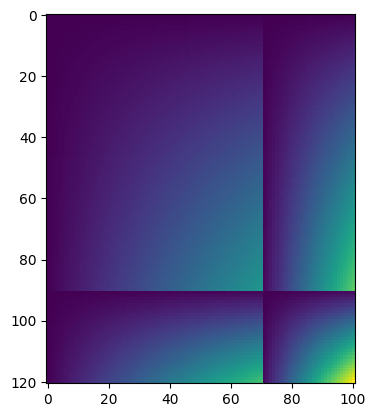

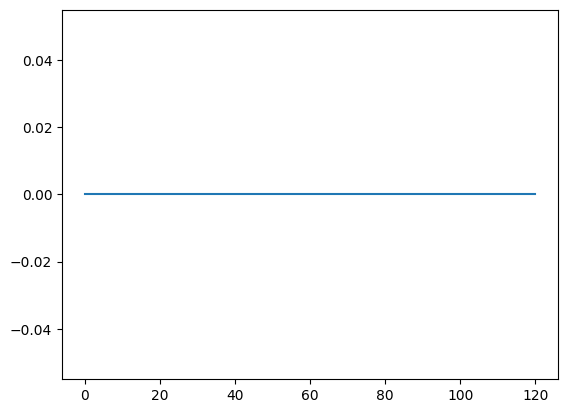

In [117]:
space_width = 120
space_height = 100

shapes = np.array([[30,60],[50,40],[60,30],[40,50]])

min_fits = np.zeros(space_width+1)
min_fits.fill(space_height+1)
for i in range(space_width):
    idx = np.where(shapes[:,0] <= i)[0]
    if len(idx) == 0:
        continue
    min_fits[i] = np.min(shapes[idx,1])


scores = np.zeros((space_width+1, space_height+1))

for x in range(space_width+1):
    for y in range(space_height+1):
        # space1_w = shape_width - x; space1_h = shape_height; space2_w = x; space2_h = shape_height - y

        min_width = np.min(shapes[:,0])
        min_height = np.min(shapes[:,1])

        width_cutoff = space_width - min_width
        height_cutoff = space_height - min_height

        score1_w = (x / space_width) * (x <= width_cutoff)
        score1_h = (y / space_height) * (y <= height_cutoff)

        # score2_w = (((x - width_cutoff) / (space_width - width_cutoff))) * (x > width_cutoff)
        # score2_h = (((y - height_cutoff) / (space_height - height_cutoff))) * (y > height_cutoff)

        p = 1
        score2_w = 1/(min_width**p) * (x - width_cutoff)**p * (x > width_cutoff)
        score2_h = 1/(min_height**p) * (y - height_cutoff)**p * (y > height_cutoff)

        width_score = score1_w + score2_w
        height_score = score1_h + score2_h

        scores[x,y] = width_score * height_score

print(scores)
print(np.max(scores))
plt.imshow(scores)